In [1]:
import torch
import torchvision
from torch import nn,optim

In [2]:
from tensorflow.python.eager.monitoring import MonitoredTimer
import numpy as np
import torchvision.transforms as transforms
from time import time
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import tensorflow as tf
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset, DataLoader
import re
import math

In [3]:
def lire_fichier(nom_fichier):
    data = []
    target = []
    
    with open(nom_fichier, 'r', encoding='utf-8') as fichier:
        for i, ligne in enumerate(fichier):
            ligne = re.sub('[\n\t]', '', ligne)
            if not ligne.strip():
                continue
            if ligne not in ["end", "<>", "<end>"]:
                elements = ligne.split(" ")
                if data:
                    data[-1].append(elements[0])
                else:
                    data.append([elements[0]])
                if target:
                    target[-1].append(elements[-1])
                else:
                    target.append([elements[-1]])
            elif ligne == "<>":
                data.append([])
                target.append([])
    
    return data, target

In [4]:
dataTrain, labelTrain =lire_fichier("protein-secondary-structure.train")
dataTest, labelTest  =lire_fichier("protein-secondary-structure.test")

In [5]:
print(dataTrain)

[['G', 'V', 'G', 'T', 'V', 'P', 'M', 'T', 'D', 'Y', 'G', 'N', 'D', 'V', 'E', 'Y', 'Y', 'G', 'Q', 'V', 'T', 'I', 'G', 'T', 'P', 'G', 'K', 'S', 'F', 'N', 'L', 'N', 'F', 'D', 'T', 'G', 'S', 'S', 'N', 'L', 'W', 'V', 'G', 'S', 'V', 'Q', 'C', 'Q', 'A', 'S', 'G', 'C', 'K', 'G', 'G', 'R', 'D', 'K', 'F', 'N', 'P', 'S', 'D', 'G', 'S', 'T', 'F', 'K', 'A', 'T', 'G', 'Y', 'D', 'A', 'S', 'I', 'G', 'Y', 'G', 'D', 'G', 'S', 'A', 'S', 'G', 'V', 'L', 'G', 'Y', 'D', 'T', 'V', 'Q', 'V', 'G', 'G', 'I', 'D', 'V', 'T', 'G', 'G', 'P', 'Q', 'I', 'Q', 'L', 'A', 'Q', 'R', 'L', 'G', 'G', 'G', 'G', 'F', 'P', 'G', 'D', 'N', 'D', 'G', 'L', 'L', 'G', 'L', 'G', 'F', 'D', 'T', 'L', 'S', 'I', 'T', 'P', 'Q', 'S', 'S', 'T', 'N', 'A', 'F', 'D', 'Q', 'V', 'S', 'A', 'Q', 'G', 'K', 'V', 'I', 'Q', 'P', 'V', 'F', 'V', 'V', 'Y', 'L', 'A', 'A', 'S', 'N', 'I', 'S', 'D', 'G', 'D', 'F', 'T', 'M', 'P', 'G', 'W', 'I', 'D', 'N', 'K', 'Y', 'G', 'G', 'T', 'L', 'L', 'N', 'T', 'N', 'I', 'D', 'A', 'G', 'E', 'G', 'Y', 'W', 'A', 'L', 'N', 'V'

In [6]:
print(labelTrain)

[['_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', 'e', 'e', '_', '_', '_', '_', '_', '_', 'e', 'e', '_', '_', 'e', 'e', 'e', '_', '_', '_', '_', '_', '_', 'e', 'e', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', 'e', 'e', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', 'e', 'e', 'e', 'e', 'e', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', 'e', 'e', 'e', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', 'h', 'h', 'h', 'h', 'h', 'h', 'h', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', 'e', 'e', 'e', '_', '_', '_', '_', '_', 'e', 'e', 'e', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', 'e', 'e', '_'

In [7]:
ac_am_dict = {
    
    "A": 0,
    "C": 1,
    "D": 2,
    "E": 3,
    "F": 4,
    "G": 5,
    "H": 6,
    "I": 7,
    "K": 8,
    "L": 9,
    "M": 10,
    "N": 11,
    "P": 12,
    "Q": 13,
    "R": 14,
    "S": 15,
    "T": 16,
    "V": 17,
    "W": 18,
    "Y": 19,
    "0": 20,    
}

targ_dict = {
    
    "_": 0,
    "e": 1,
    "h": 2,
    "0": 3,   
}

In [8]:
def TransformAcideAmin(DataFrame):
    
     #Normalisation pour avoir des protein de meme taill 
    for i,row in DataFrame.iterrows():
        
        
        if 497 != len(row['acideAmine']):
            more= 497 - len(row['acideAmine'])
            row['acideAmine'].extend(['0']*more)
            
        #remplissage avec padding des 0
        if 497 != len(row['label']):
            
            more=497 - len(row['label'])
            row['label'].extend(['0']*more)
        #une fois le row transformé je l'ajout au data frame
        DataFrame.at[i,'acideAmine'] = row['acideAmine']
        DataFrame.at[i,'label'] = row['label']
    

    #a cette étapes j'ai un dataframes de proteines et target avec le padding mais encore avec les données brute  
    for i,row in DataFrame.iterrows():
        
        a = []
        #chaq acide  sera remplacé par son numéro du dictionnaire
        for acide in row['acideAmine']:    
            a.append(ac_am_dict[acide])
            


        DataFrame.at[i,"acideAmine"] = a
      
        target = []
        #chaq target  sera remplacé par son numéro du dictionnaire
        for trgt in row['label']:
            target.append(targ_dict[trgt])
            
        DataFrame.at[i,"label"] = target
    
        

    return DataFrame

In [9]:
#Je crée le dataframe qui sera l'entrée de TransformAcideAmin
train = pd.DataFrame({'acideAmine':dataTrain,'label':labelTrain})
test = pd.DataFrame({'acideAmine':dataTest,'label':labelTest})


FinaleTRAIN = TransformAcideAmin(train)
FinaleTest = TransformAcideAmin(test)
print(FinaleTRAIN)
print("===============================================")
print(FinaleTest)

                                            acideAmine  \
0    [5, 17, 5, 16, 17, 12, 10, 16, 2, 19, 5, 11, 2...   
1    [0, 13, 1, 3, 0, 16, 7, 3, 15, 11, 2, 0, 10, 1...   
2    [15, 17, 2, 7, 13, 5, 11, 2, 13, 10, 13, 4, 11...   
3    [0, 9, 18, 13, 4, 11, 5, 10, 7, 8, 1, 8, 7, 12...   
4    [6, 18, 5, 19, 5, 8, 6, 2, 5, 12, 3, 6, 18, 6,...   
..                                                 ...   
106  [0, 16, 9, 8, 3, 8, 9, 7, 0, 12, 17, 0, 13, 13...   
107  [14, 12, 2, 4, 1, 9, 3, 12, 12, 19, 16, 5, 12,...   
108  [10, 8, 8, 19, 16, 1, 16, 17, 1, 5, 19, 7, 19,...   
109  [15, 16, 0, 5, 8, 17, 7, 8, 1, 8, 0, 0, 17, 9,...   
110  [11, 14, 2, 12, 0, 15, 2, 13, 10, 8, 6, 18, 8,...   

                                                 label  
0    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1    [0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...  
2    [0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3    [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, ...  
4    [0, 0, 0, 0, 

In [10]:
print(FinaleTRAIN.shape)
print(len(FinaleTRAIN))
print(FinaleTest.shape)

(111, 2)
111
(17, 2)


In [11]:
x_train_int = np.array(FinaleTRAIN['acideAmine'].to_list(), dtype = object)
y_train_int = np.array(FinaleTRAIN['label'].to_list(), dtype = object)
x_test_int = np.array(FinaleTest['acideAmine'].to_list(), dtype = object)
y_test_int = np.array(FinaleTest['label'].to_list(), dtype = object)

In [12]:
print(x_train_int)

[list([5, 17, 5, 16, 17, 12, 10, 16, 2, 19, 5, 11, 2, 17, 3, 19, 19, 5, 13, 17, 16, 7, 5, 16, 12, 5, 8, 15, 4, 11, 9, 11, 4, 2, 16, 5, 15, 15, 11, 9, 18, 17, 5, 15, 17, 13, 1, 13, 0, 15, 5, 1, 8, 5, 5, 14, 2, 8, 4, 11, 12, 15, 2, 5, 15, 16, 4, 8, 0, 16, 5, 19, 2, 0, 15, 7, 5, 19, 5, 2, 5, 15, 0, 15, 5, 17, 9, 5, 19, 2, 16, 17, 13, 17, 5, 5, 7, 2, 17, 16, 5, 5, 12, 13, 7, 13, 9, 0, 13, 14, 9, 5, 5, 5, 5, 4, 12, 5, 2, 11, 2, 5, 9, 9, 5, 9, 5, 4, 2, 16, 9, 15, 7, 16, 12, 13, 15, 15, 16, 11, 0, 4, 2, 13, 17, 15, 0, 13, 5, 8, 17, 7, 13, 12, 17, 4, 17, 17, 19, 9, 0, 0, 15, 11, 7, 15, 2, 5, 2, 4, 16, 10, 12, 5, 18, 7, 2, 11, 8, 19, 5, 5, 16, 9, 9, 11, 16, 11, 7, 2, 0, 5, 3, 5, 19, 18, 0, 9, 11, 17, 16, 5, 0, 16, 0, 2, 15, 16, 19, 9, 5, 0, 7, 4, 13, 0, 7, 9, 2, 16, 5, 16, 15, 9, 9, 7, 9, 12, 2, 3, 0, 0, 17, 5, 11, 9, 17, 5, 4, 0, 5, 0, 13, 2, 0, 0, 9, 5, 5, 4, 17, 7, 0, 1, 16, 15, 0, 5, 4, 8, 15, 7, 12, 18, 15, 7, 19, 15, 0, 7, 4, 3, 7, 7, 16, 0, 9, 5, 11, 0, 3, 2, 2, 15, 5, 1, 16, 15, 5, 7, 5

In [13]:
x_train_int.shape

(111,)

In [14]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [15]:
x_train_padded = pad_sequences(x_train_int, padding='post')
y_train_padded = pad_sequences(y_train_int, padding='post')
x_test_padded = pad_sequences(x_test_int, padding= 'post')
y_test_padded = pad_sequences(y_test_int, padding= 'post')


In [16]:
print(x_train_padded)

[[ 5 17  5 ... 20 20  0]
 [ 0 13  1 ... 20 20  0]
 [15 17  2 ... 20 20  0]
 ...
 [10  8  8 ... 20 20  0]
 [15 16  0 ... 20 20  0]
 [11 14  2 ...  8 19 11]]


In [17]:
print(x_train_padded.shape)
print(y_train_padded.shape)
print(x_test_padded.shape)
print(y_test_padded.shape)

(111, 498)
(111, 498)
(17, 497)
(17, 497)


In [18]:
x_train = torch.from_numpy(tf.one_hot(x_train_padded, depth =21).numpy())
y_train = torch.from_numpy(tf.one_hot(y_train_padded, depth =4).numpy())
x_test = torch.from_numpy(tf.one_hot(x_test_padded, depth =21).numpy())
y_test = torch.from_numpy(tf.one_hot(y_test_padded, depth =4).numpy())


In [19]:
print(x_train)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [1., 0., 0.,  ..., 0., 0., 0.]],

        [[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [1., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [1., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0., 

In [20]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

torch.Size([111, 498, 21])
torch.Size([111, 498, 4])
torch.Size([17, 497, 21])
torch.Size([17, 497, 4])


In [21]:
from torch.utils.data import DataLoader, TensorDataset

In [22]:
traindata = TensorDataset(x_train,y_train)
testdata = TensorDataset(x_test,y_test)

In [23]:
print(len(traindata))
print(len(testdata))

111
17


In [24]:
loadtrain = DataLoader(traindata, batch_size =16 )
loadtest = DataLoader(testdata, batch_size = 16)

In [25]:
print(len(loadtrain))
print(len(loadtest))

7
2


In [26]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


# Hyper-parameters 
num_epochs = 2
batch_size = 64
learning_rate = 0.1
input_size = 21
hidden_size = 16
num_layers = 2


class NeuralNetwork(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers):

        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.num_layers = 2
        self.hidden_size = 16
        self.gru = nn.GRU(input_size, 17, num_layers*2, batch_first=True,bidirectional=True)
        self.fc = nn.Linear(34, 4)
        self.relu = nn.ReLU()
    def forward(self, x,h0):  
        out, o = self.gru(x, h0)   
        a = nn.Sequential( 
            self.relu,
            self.fc)  
        out = a(out)
        return out , o
          
    def init_hidden(self, batch_size):
        
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        


model =  NeuralNetwork(input_size, hidden_size, num_layers)


In [27]:
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (gru): GRU(21, 17, num_layers=4, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=34, out_features=4, bias=True)
  (relu): ReLU()
)


In [28]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    train_loss_total = 0
    correct_predictions = 0
    for batch, (X, y) in enumerate(dataloader.dataset):
        
        h = model.init_hidden(len(X))
        p , h =model(X,h)
        loss = loss_fn(p, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update training loss and accuracy
        train_loss_total += loss.item()
        pred_labels = torch.argmax(p, dim=1)
        true_labels = torch.argmax(y, dim=1)
        correct_predictions += torch.sum(pred_labels == true_labels).item()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  ")
    
    # Compute average training loss and accuracy
    train_loss = train_loss_total / len(dataloader)
    train_accuracy = correct_predictions / size
    
    return train_loss, train_accuracy


In [29]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    print(num_batches)
    test_loss, correct = 0, 0
    size_no_padding=0

    with torch.no_grad():
        for X, y in dataloader:
            
            h = model.init_hidden(len(X))
            pred , h =model(X,h) ##################
            
            #Etape pour enlevé le padding qui faussé les résulat et me donner des accuracy 
            #illogiquement élevé
            mask = (torch.ones(y.shape[0], y.shape[1])*(y.shape[2]-1))!= y.argmax(dim=2)
            pred_no_padding = torch.masked_select(pred.argmax(dim=2), mask)
            y_no_padding = torch.masked_select(y.argmax(dim=2), mask)
            
            correct += (pred_no_padding == y_no_padding).type(torch.float).sum().item()   # compte du nombre de prédiction correctes
            size_no_padding += len(pred_no_padding)
            
            loss = loss_fn(pred, y)
            test_loss += loss_fn(pred, y).item()

    #''' test_loss /= num_batches
    correct /= size_no_padding 
    
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return test_loss, correct


In [30]:
loss_fn = nn.MSELoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=0.1,momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialiser les paramètres pour l'early stopping
best_loss = np.inf
patience = 5
no_improvement = 0
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
num_epoch = 100

# Boucle d'entraînement avec early stopping
for epoch in range(num_epoch):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss, train_accuracy = train_loop(loadtrain, model, loss_fn, optimizer)
    val_loss, val_accuracy = test_loop(loadtest, model,  loss_fn)

    # Enregistrer le modèle s'il a la meilleure performance de validation
    if val_loss < best_loss:
        torch.save(model.state_dict(), 'best_model.pt')
        best_loss = val_loss
        no_improvement = 0
        print(f"Validation loss improved to {val_loss:.4f}")
    else:
        no_improvement += 1
        print(f"No improvement in validation loss")
    
    # Vérifier si l'early stopping doit être appliqué
    if no_improvement >= patience:
        print(f"Early stopping after {epoch+1} epochs without improvement in validation loss.")
        break

    # Enregistrer les métriques d'entraînement et de validation
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

print("Done!")


Epoch 1
-------------------------------
loss: 0.251473  
loss: 0.047611  
2
Test Error: 
 Accuracy: 54.3%, Avg loss: 0.079698 

Validation loss improved to 0.0797
Epoch 2
-------------------------------
loss: 0.072051  
loss: 0.046300  
2
Test Error: 
 Accuracy: 54.5%, Avg loss: 0.077937 

Validation loss improved to 0.0779
Epoch 3
-------------------------------
loss: 0.069413  
loss: 0.043917  
2
Test Error: 
 Accuracy: 54.6%, Avg loss: 0.075660 

Validation loss improved to 0.0757
Epoch 4
-------------------------------
loss: 0.064999  
loss: 0.040591  
2
Test Error: 
 Accuracy: 54.7%, Avg loss: 0.071635 

Validation loss improved to 0.0716
Epoch 5
-------------------------------
loss: 0.057430  
loss: 0.037660  
2
Test Error: 
 Accuracy: 57.0%, Avg loss: 0.071193 

Validation loss improved to 0.0712
Epoch 6
-------------------------------
loss: 0.052030  
loss: 0.035215  
2
Test Error: 
 Accuracy: 59.5%, Avg loss: 0.068235 

Validation loss improved to 0.0682
Epoch 7
--------------

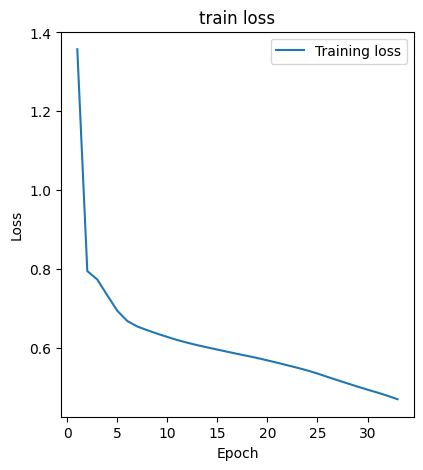

In [45]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training loss')
#plt.plot(epochs, val_losses, label='Validation loss')
plt.title('train loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

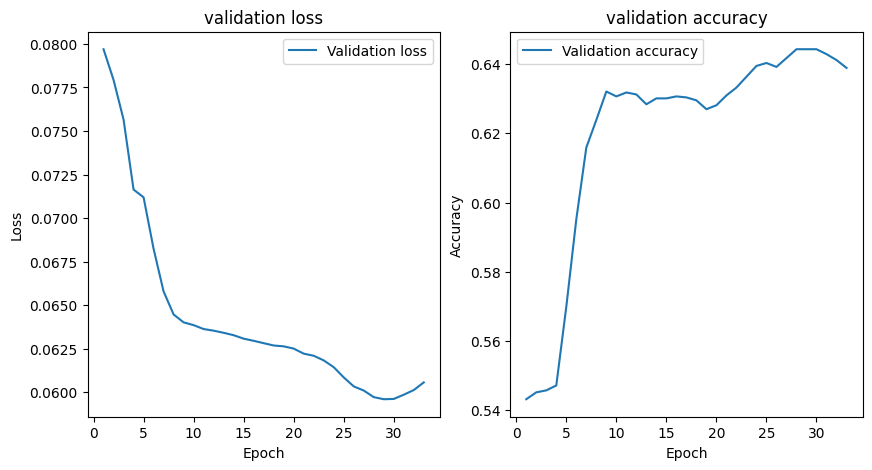

In [46]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
#plt.plot(epochs, train_losses, label='Training loss')
plt.plot(epochs, val_losses, label='Validation loss')
plt.title('validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
#plt.plot(epochs, train_accuracies, label='Training accuracy')
plt.plot(epochs, val_accuracies, label='Validation accuracy')
plt.title('validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()